In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import GPT2Model, GPT2Config, PreTrainedModel
from sru import SRUpp
from datasets import load_dataset, Dataset, DatasetDict

from torch.utils.data import DataLoader
from transformers import Trainer, TrainingArguments

import math
import numpy as np

import logging
logging.disable(logging.INFO)

# Competitive edge techniques:
- Custom loss function based on profit with trade sizing (more of a conceptual innovation)
- multiloss to integrate shorter and longer trades (practical innovation to unlock longer times and more data and better gradients)
- best models -- most people don't really understand how transformers even work let alone sru
- the way I normalize the data in preprocessing may be better?

- right now model is quite greedy (for my own sanity), but it's totally possible to consider more of a <50% accuracy model but just with higher upside
- the linear loss is odd to say the least in some sense having a strong bias for "opportunity cost"

TODO:
- change learning rate
- increase dropout

In [2]:
class SRUTrader(PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        
        config.initializer_range = 1 / math.sqrt(config.n_embd)
        
        self.embed = nn.Linear(5, config.n_embd, bias = False)
        self.norm = nn.LayerNorm(config.n_embd)
        self.sru = SRUpp(input_size = config.n_embd,
                         hidden_size = config.n_embd,
                         proj_size = 4 * config.n_embd, # paper says 8 is better, but working with memory contraints
                         num_layers = 10, # paper seemed to have tuned to find this to work
                         dropout = .1,
                         attn_dropout = .1,
                         rescale = True,
                         layer_norm = True,
                         num_heads = config.n_head,
                         attention_every_n_layers = 2,
                         amp_recurrence_fp16 = True)
        self.trade = nn.Linear(config.n_embd, 120, bias = False)
        self.trade_sign = nn.Parameter(torch.Tensor([-1, 1]), requires_grad = True)

        self.ce_loss = nn.CrossEntropyLoss(reduction = 'none')


    def forward(self, ohlcv, future):
        # manual positional embeddings
        batch_size, seq_len, _ = ohlcv.shape
        
        mask = torch.triu(torch.ones(seq_len, seq_len, device = ohlcv.device), diagonal=1) * -10000.0
        
        embed = self.norm(self.embed(ohlcv))
        embed = torch.permute(embed, (1, 0, 2)) # sequence first for SRU
        hidden = torch.permute(
            self.sru(embed, attn_mask = mask)[0], (1, 0, 2)
        )
        
        soft_trade = self.trade(hidden)
        
        classes = torch.where(future != 0, (future > 0).long(), -100)
        ce_loss = self.ce_loss(soft_trade.reshape(-1, 2), classes.reshape(-1))
        
        soft_trade = F.softmax(soft_trade.reshape(batch_size, seq_len, 60, 2), dim = -1)
        soft_trade = (soft_trade * self.trade_sign).sum(dim = -1)
        soft_profit = soft_trade * future
        abs_future = future.abs()
        
        # cost scaled CrossEntropyLoss
        cost_scaling = abs_future / abs_future.std(dim = (1, 2)).reshape(-1, 1, 1)
        classification_loss = (ce_loss * cost_scaling.reshape(-1)).mean()
        
        # profit loss on the day
        profit_loss = -torch.log(
            (soft_profit.mean(dim = (1, 2)) / abs_future.mean(dim = (1, 2)) + 1) / 2
        )
        profit_loss = profit_loss.mean()
        
        loss = .5 * classification_loss + .5 * profit_loss
        
        return {
            'loss': loss,
            'profits': soft_profit,
            'trades': soft_trade,
        }

In [3]:
def compute_metrics(preds):
    soft_profit, soft_trade = preds.predictions
    abs_trade = np.abs(soft_trade)
    abs_trade = abs_trade.astype('float64') # half precision will cause the sum to overflow on next line
    trades = abs_trade.sum()
    
    day_profits = soft_profit.sum(axis = (1, 2))
    
    metrics = {
        'day profit': day_profits.mean(),
        'day sharpe': day_profits.mean() / day_profits.std(),
        'trade %': trades * 100 / soft_profit.size,
        
        'full trade %': (abs_trade >= .8).mean() * 100,
        'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
        'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
                          / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),
        
        'medium trade %': ((abs_trade < .8) & (abs_trade >= .5)).mean() * 100,
        'medium trade accuracy': (soft_profit[(abs_trade < .8) & (abs_trade >= .5)] > 0).mean() * 100,
        'medium trade g/l': soft_profit[(abs_trade < .8) & (abs_trade >= .5) & (soft_profit > 0)].mean()
                            / -soft_profit[(abs_trade < .8) & (abs_trade >= .5) & (soft_profit < 0)].mean(),       
        
        'small trade %': ((abs_trade < .5) & (abs_trade >= .2)).mean() * 100,
        'small trade accuracy': (soft_profit[(abs_trade < .5) & (abs_trade >= .2)] > 0).mean() * 100,
        'small trade g/l': soft_profit[(abs_trade < .5) & (abs_trade >= .2) & (soft_profit > 0)].mean()
                            / -soft_profit[(abs_trade < .5) & (abs_trade >= .2) & (soft_profit < 0)].mean(),
    }
    
    # round the metrics
    metrics = {k: np.format_float_positional(v, precision = 4) for k, v in metrics.items()}
    
    return metrics

In [4]:
fx = Dataset.load_from_disk('data/fx_days.ds')

# make splits
split = fx.train_test_split(.004, shuffle = False)
valid_test = split['test'].train_test_split(.5, shuffle = False)
fx = DatasetDict({
    'train': split['train'],
    'validation': valid_test['train'],
    'test': valid_test['test']
})

In [12]:
training_args = TrainingArguments(
    output_dir = "./results",
    logging_strategy = "steps",
    evaluation_strategy = "steps",
    logging_steps = 500,
    eval_steps = 500,
    report_to = "none",
    learning_rate = 5e-5,
    weight_decay = .01,
    lr_scheduler_type = "cosine",
    warmup_ratio = .05,
    num_train_epochs = 1,
    per_device_train_batch_size = 2,
    per_device_eval_batch_size = 2,
    max_grad_norm = 1,
    fp16 = True,
)

In [13]:
config = GPT2Config(
    n_embd = 448, n_positions = 2000, n_head = 7
)

In [14]:
model = SRUTrader(config)
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = fx['train'],
    eval_dataset = fx['validation'],
    compute_metrics = compute_metrics
)

In [8]:
# sru lr of 5e-5, batch size 2 hidden size 448, 60 min, 
# fp16, no slippage, binary class with DAY loss scaling, and DAY log loss, rotary embeddings, .1 dropout
# weight decay
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,0.679900,0.667717,0.309,0.6136,10.1227,0.,nan,nan,0.0067,57.9365,1.3279,10.6929,54.7745,1.0226
1000,0.673300,0.670522,0.2812,0.2457,12.7727,0.0000,100.,nan,0.2086,58.1149,1.2214,21.9607,53.2218,0.9756
1500,0.667800,0.668638,0.4455,0.2638,15.4723,0.0000,100.,nan,0.1753,62.5356,1.3863,31.0784,53.0426,0.9852
2000,0.670700,0.667565,0.4815,1.1844,14.9786,0.1738,70.4580,1.4115,3.1169,58.0913,1.1208,22.2512,52.6552,1.0219
2500,0.670500,0.669192,0.298,0.3443,12.6004,0.0064,83.4734,1.2911,1.2819,60.6606,1.3205,17.9925,53.4743,1.0159
3000,0.669800,0.669653,0.3857,0.312,15.3189,0.2463,73.2432,1.5325,2.8473,61.6672,1.2851,22.2756,52.3333,1.019
3500,0.668600,0.664385,0.5025,0.9559,12.1316,0.165,74.6141,1.5665,2.0310,63.8273,1.3605,13.7223,54.6318,1.0893
4000,0.670400,0.666223,0.7582,1.0701,20.1796,0.4864,68.5384,1.4666,6.5777,57.4575,1.1820,32.3013,52.2641,1.0232
4500,0.668400,0.665356,0.8131,1.0423,20.6818,0.5194,68.2013,1.3624,6.1346,56.912,1.1458,35.3052,52.5424,1.0297
5000,0.668900,0.664721,0.4654,0.736,10.6567,0.0559,78.6692,1.6157,1.6933,65.6925,1.3249,11.3179,55.0790,1.0778


<ipython-input-3-3fb8edfb8ee8>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-3fb8edfb8ee8>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-3fb8edfb8ee8>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),
<ipython-input-3-3fb8edfb8ee8>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value enc

TrainOutput(global_step=16111, training_loss=0.6672849917380728, metrics={'train_runtime': 5533.5155, 'train_samples_per_second': 5.823, 'train_steps_per_second': 2.912, 'total_flos': 0.0, 'train_loss': 0.6672849917380728, 'epoch': 1.0})

In [8]:
# sru lr of 5e-5, batch size 2 hidden size 448, 60 min, 
# fp16, no slippage, binary class with DAY loss scaling, and DAY log loss, rotary embeddings, .1 dropout
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,0.680500,0.667647,0.3114,0.5908,10.0755,0.,nan,nan,0.0075,57.9196,0.9711,11.0883,54.7895,1.0224
1000,0.673300,0.670634,0.2631,0.2294,12.3602,0.0001,33.3333,1.2661,0.0437,60.2444,1.1954,21.2140,53.3551,0.9776
1500,0.667900,0.668867,0.4586,0.2560,15.7402,0.0002,36.3636,0.7455,0.0606,65.3643,1.2017,33.6348,53.0146,0.9879
2000,0.670800,0.666689,0.4206,1.2814,12.8063,0.0193,77.2643,1.5732,1.3239,61.0782,1.2401,18.6163,53.5994,1.0377
2500,0.670500,0.669609,0.2843,0.3035,12.8751,0.0059,83.2827,1.5311,1.0444,62.4471,1.3199,19.0062,53.4614,1.0183
3000,0.669900,0.669709,0.5312,0.4535,17.7662,0.6135,67.5229,1.2954,5.2612,58.0191,1.1648,26.4502,51.5704,1.007
3500,0.668500,0.664106,0.5441,1.0660,12.7102,0.1776,73.8071,1.5221,2.4326,62.0532,1.3646,15.2072,54.1487,1.0748
4000,0.670600,0.666503,0.7142,1.1237,19.3573,0.3953,68.9220,1.4142,6.016,57.6216,1.1605,31.2604,52.2923,1.0215
4500,0.668500,0.665246,0.7904,1.0239,20.3753,0.513,68.1777,1.4272,5.9732,56.8721,1.1537,34.0396,52.5492,1.0324
5000,0.668900,0.665192,0.4862,0.7165,11.9149,0.1506,75.8898,1.4948,2.3686,63.5278,1.2679,13.4627,53.9674,1.0399


<ipython-input-3-3fb8edfb8ee8>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-3fb8edfb8ee8>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-3fb8edfb8ee8>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),


TrainOutput(global_step=16111, training_loss=0.6673555050354402, metrics={'train_runtime': 5592.7368, 'train_samples_per_second': 5.761, 'train_steps_per_second': 2.881, 'total_flos': 0.0, 'train_loss': 0.6673555050354402, 'epoch': 1.0})

In [8]:
# sru lr of 5e-5, batch size 2 hidden size 448, 60 min, 
# fp16, no slippage, binary class with DAY loss scaling, and DAY log loss, rotary embeddings, no dropout
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,0.676600,0.667986,0.3118,0.5426,10.5003,0.,nan,nan,0.0178,55.0551,1.0320,12.4403,54.368,1.0089
1000,0.671200,0.669581,0.3749,0.3881,14.5671,0.0003,47.3684,0.8206,0.9144,58.6902,1.1759,26.4858,52.9174,0.9905
1500,0.666400,0.667045,0.4553,0.3227,14.5275,0.0020,64.9123,3.2295,0.5051,65.8441,1.4508,24.7535,53.4589,0.9878
2000,0.669600,0.667262,0.5079,1.2419,15.2955,0.2212,71.3228,1.4015,3.1617,58.8088,1.1587,23.3594,52.6139,1.0211
2500,0.669200,0.670520,0.1947,0.2038,11.53,0.0046,75.969,1.3663,0.5566,64.3719,1.4147,13.7259,53.9661,1.0120
3000,0.669100,0.669249,0.3386,0.3203,13.9809,0.251,73.0472,1.5831,2.5946,62.5581,1.3439,17.3772,52.6259,1.0408
3500,0.667800,0.664721,0.4896,0.9349,11.5659,0.2523,73.6731,1.4788,2.7170,62.172,1.4102,12.3213,54.1254,1.1029
4000,0.669900,0.665422,0.6884,1.1544,18.0964,0.5416,67.4404,1.4695,5.5458,58.2599,1.235,27.0392,52.4605,1.038
4500,0.668000,0.664921,0.7161,1.0645,18.5690,0.4668,69.1157,1.4593,5.3548,57.5591,1.1948,29.6764,52.5816,1.038
5000,0.668400,0.665028,0.4341,0.7712,9.8726,0.1183,75.4666,1.5224,1.9298,64.3753,1.3552,8.8836,55.1708,1.1412


<ipython-input-3-3fb8edfb8ee8>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-3fb8edfb8ee8>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-3fb8edfb8ee8>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),


TrainOutput(global_step=16111, training_loss=0.6667332265949895, metrics={'train_runtime': 5310.533, 'train_samples_per_second': 6.067, 'train_steps_per_second': 3.034, 'total_flos': 0.0, 'train_loss': 0.6667332265949895, 'epoch': 1.0})

In [12]:
# sru lr of 5e-5, batch size 2 hidden size 448, 60 min, 
# fp16, no slippage, binary class with DAY loss scaling, and DAY log loss, rotary embeddings
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,0.677200,0.667789,0.3327,0.588,10.9604,0.,nan,nan,0.0806,54.8024,1.0317,13.8542,54.3252,1.0323
1000,0.671500,0.669402,0.381,0.3997,14.5551,0.0001,75.,0.8178,0.7412,58.9770,1.1952,26.8307,52.8913,0.9906
1500,0.666600,0.667241,0.4628,0.3149,14.9573,0.0009,79.2453,1.5118,0.4593,63.4513,1.4773,26.2578,53.4318,0.9914
2000,0.669800,0.666950,0.4344,1.7577,13.3486,0.0725,76.3145,1.4079,1.5772,61.0479,1.2025,19.6249,53.2407,1.0227
2500,0.669500,0.670351,0.2044,0.2143,11.5228,0.003,77.2455,1.2084,0.5451,63.9871,1.3224,13.3035,54.2148,1.0316
3000,0.669400,0.668914,0.3833,0.3654,14.5910,0.312,72.2945,1.5596,2.9361,61.4058,1.2770,18.6414,52.5920,1.0361
3500,0.667800,0.664437,0.5551,1.0815,12.8943,0.3357,72.4674,1.5753,3.4912,60.9957,1.3263,14.1917,53.4401,1.0616
4000,0.669900,0.665377,0.6612,1.0966,17.4433,0.5337,68.4284,1.5413,5.3938,58.2571,1.2357,24.6477,52.505,1.0466
4500,0.668000,0.665090,0.7096,1.0729,18.4999,0.514,68.6829,1.4046,5.5117,57.2389,1.1773,28.7346,52.5045,1.0338
5000,0.668500,0.665113,0.4513,0.7711,10.4607,0.1617,75.1239,1.5418,2.2077,64.0761,1.3219,10.1639,54.6315,1.0895


<ipython-input-7-3fb8edfb8ee8>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-7-3fb8edfb8ee8>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-7-3fb8edfb8ee8>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),


TrainOutput(global_step=16111, training_loss=0.6668349540653149, metrics={'train_runtime': 5532.1125, 'train_samples_per_second': 5.824, 'train_steps_per_second': 2.912, 'total_flos': 0.0, 'train_loss': 0.6668349540653149, 'epoch': 1.0})

In [9]:
trainer.evaluate(fx['test'])

{'eval_loss': 1.2046549320220947,
 'eval_day sharpe': '0.7004',
 'eval_trade %': '7.9092',
 'eval_full trade %': '0.0328',
 'eval_full trade accuracy': '85.9392',
 'eval_full trade g/l': '2.5981',
 'eval_medium trade %': '0.7888',
 'eval_medium trade accuracy': '74.4119',
 'eval_medium trade g/l': '1.6208',
 'eval_small trade %': '6.7866',
 'eval_small trade accuracy': '57.5515',
 'eval_small trade g/l': '1.1687',
 'eval_runtime': 7.4916,
 'eval_samples_per_second': 8.676,
 'eval_steps_per_second': 4.405,
 'epoch': 1.0}

In [10]:
trainer.save_model('srupp.model')

# quick prediction test to ensure model isn't cheating

In [11]:
model = SRUTrader.from_pretrained('srupp.model', config = config).cuda().eval()

0


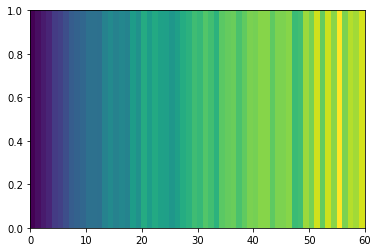

tensor([-94., -91., -88., -86., -80., -79., -76., -71., -70., -68., -65., -65.,
        -65., -59., -57., -59., -58., -59., -51., -55., -46., -51., -47., -49.,
        -50., -53., -50., -46., -44., -40., -41., -37., -39., -44., -35., -34.,
        -33., -38., -35., -31., -32., -30., -30., -35., -31., -31., -30., -41.,
        -39., -27., -32., -21., -34., -22., -30., -16., -31., -24., -26., -21.])


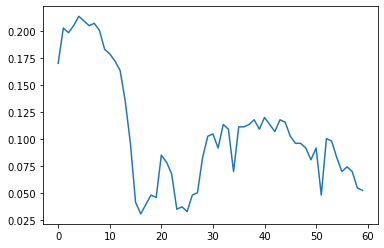

1


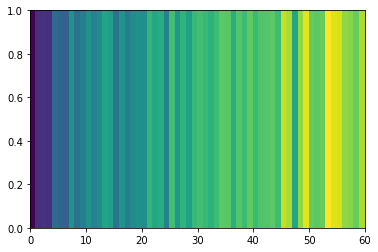

tensor([-69., -58., -58., -58., -42., -43., -45., -29., -39., -36., -29., -34.,
        -31., -23., -25., -39., -28., -36., -31., -29., -30., -17., -22., -20.,
        -34., -14., -27., -18., -24., -16., -14., -16., -18., -15., -11., -11.,
        -19., -12., -15., -10., -16., -12., -11., -10., -15.,   3.,  -1., -22.,
         -3.,   6.,  -9., -10.,  -9.,  10.,   6.,   5.,  -3.,  -5.,  -9.,  -0.])


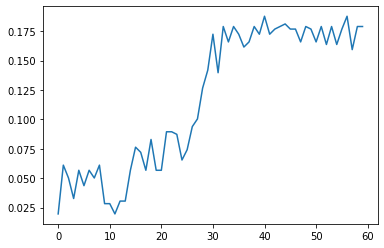

2


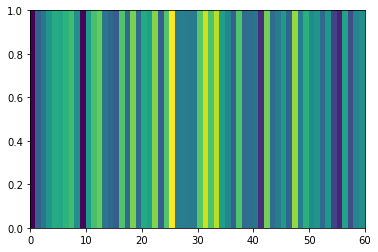

tensor([19., 27., 29., 32., 34., 34., 35., 36., 31., 19., 32., 36., 38., 29.,
        27., 26., 37., 27., 39., 28., 34., 33., 39., 26., 37., 43., 29., 29.,
        29., 29., 37., 42., 37., 41., 33., 30., 27., 37., 28., 28., 28., 22.,
        38., 28., 29., 32., 27., 40., 29., 35., 31., 32., 27., 32., 24., 21.,
        33., 25., 30., 31.])


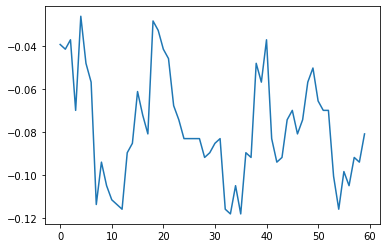

3


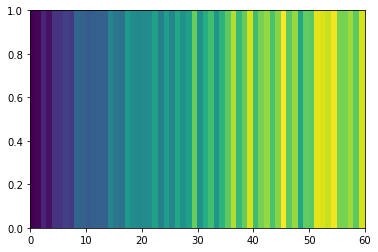

tensor([-97., -95., -88., -93., -84., -84., -81., -83., -70., -70., -73., -71.,
        -71., -71., -59., -64., -65., -52., -56., -58., -57., -56., -49., -61.,
        -50., -58., -47., -55., -49., -32., -54., -45., -39., -53., -43., -34.,
        -24., -41., -33., -19., -40., -31., -27., -37., -29., -14., -34., -26.,
        -47., -34., -35., -17., -18., -20., -15., -31., -31., -25., -35., -18.])


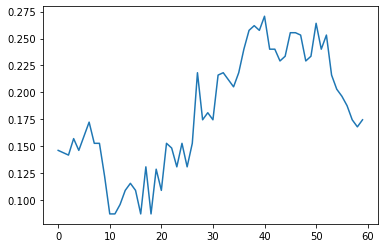

In [12]:
import matplotlib.pyplot as plt

for day in range(4):
    # cut data short so no backwards flow of info
    test_day = torch.tensor(fx['validation']['ohlcv'][day][:]).unsqueeze(0).cuda()
    test_futures = torch.tensor(fx['validation']['future'][day][:]).unsqueeze(0).cuda()
    after = torch.tensor(fx['validation']['ohlcv'][day][1440 - 1380:1440-1320])
    with torch.no_grad():
        # no access to futures
        pred = model(test_day, test_futures)['trades'][0][60]
    torch.cuda.empty_cache()
#     if (pred.abs() >= .9).any():
    if True:
        print(day)
        plt.pcolormesh(pred.cpu().unsqueeze(0))
        plt.show()
        print((pred.cpu() * 100).round())
        
        plt.plot(after.select(dim = 1, index = -1))
        plt.show()

0


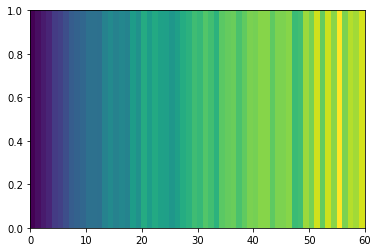

tensor([-94., -91., -88., -86., -80., -79., -76., -71., -70., -68., -65., -65.,
        -65., -59., -57., -59., -58., -59., -51., -55., -46., -51., -47., -49.,
        -50., -53., -50., -46., -44., -40., -41., -37., -39., -44., -35., -34.,
        -33., -38., -35., -31., -32., -30., -30., -35., -31., -31., -30., -41.,
        -39., -27., -32., -21., -34., -22., -30., -16., -31., -24., -26., -21.])


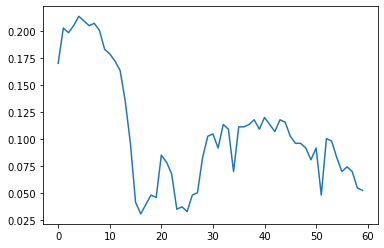

1


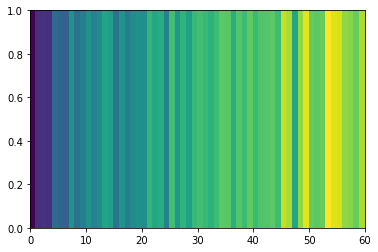

tensor([-69., -58., -58., -58., -42., -43., -45., -29., -39., -36., -29., -34.,
        -31., -23., -25., -39., -28., -36., -31., -29., -30., -17., -22., -20.,
        -34., -14., -27., -18., -24., -16., -14., -16., -18., -15., -11., -11.,
        -19., -12., -15., -10., -16., -12., -11., -10., -15.,   3.,  -1., -22.,
         -3.,   6.,  -9., -10.,  -9.,  10.,   6.,   5.,  -3.,  -5.,  -9.,  -0.])


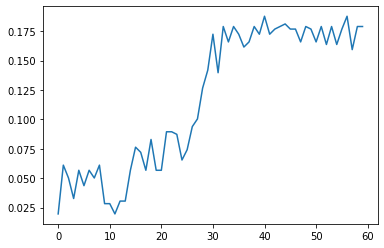

2


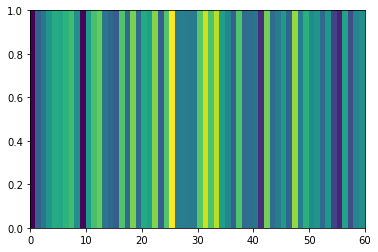

tensor([19., 27., 29., 32., 34., 34., 35., 36., 31., 19., 32., 36., 38., 29.,
        27., 26., 37., 27., 39., 28., 34., 33., 39., 26., 37., 43., 29., 29.,
        29., 29., 37., 42., 37., 41., 33., 30., 27., 37., 28., 28., 28., 22.,
        38., 28., 29., 32., 27., 40., 29., 35., 31., 32., 27., 32., 24., 21.,
        33., 25., 30., 31.])


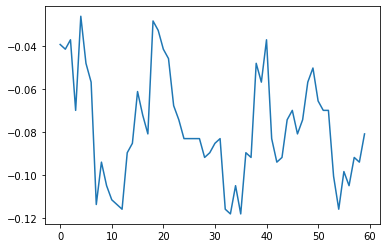

3


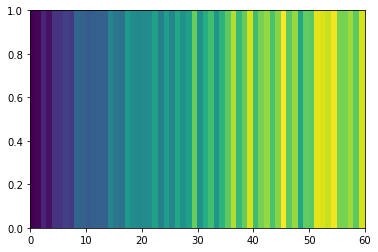

tensor([-97., -95., -88., -93., -84., -84., -81., -83., -70., -70., -73., -71.,
        -71., -71., -59., -64., -65., -52., -56., -58., -57., -56., -49., -61.,
        -50., -58., -47., -55., -49., -32., -54., -45., -39., -53., -43., -34.,
        -24., -41., -33., -19., -40., -31., -27., -37., -29., -14., -34., -26.,
        -47., -34., -35., -17., -18., -20., -15., -31., -31., -25., -35., -18.])


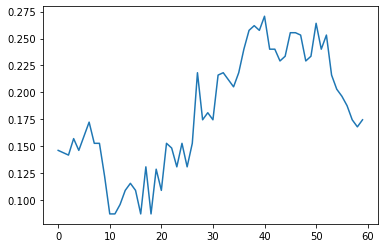

In [13]:
import matplotlib.pyplot as plt

for day in range(4):
    # cut data short so no backwards flow of info
    test_day = torch.tensor(fx['validation']['ohlcv'][day][:61]).unsqueeze(0).cuda()
    after = torch.tensor(fx['validation']['ohlcv'][day][1440 - 1380:1440 - 1320])
    with torch.no_grad():
        # no access to futures
        pred = model(test_day, torch.zeros(1, 61, 60).cuda())['trades'][0][60]
    torch.cuda.empty_cache()
#     if (pred.abs() >= .9).any():
    if True:
        print(day)
        plt.pcolormesh(pred.cpu().unsqueeze(0))
        plt.show()
        print((pred.cpu() * 100).round())
        
        plt.plot(after.select(dim = 1, index = -1))
        plt.show()

# TODO: graph these instead of showing raw data (maybe even on same plot or at least side by side)

In [14]:
soft_profit, soft_trade = trainer.predict(fx['validation']).predictions

In [15]:
# full trade percent on 24 hours, ignoring last hour, it makes most trades in london and ny sessions (esp overlap)
(np.abs(soft_trade) > .8).mean(axis = (0, 2)).reshape(-1, 60).mean(axis = 1).round(3)

array([0.115, 0.087, 0.052, 0.017, 0.011, 0.012, 0.018, 0.026, 0.023,
       0.008, 0.002, 0.002, 0.003, 0.004, 0.004, 0.003, 0.002, 0.001,
       0.002, 0.004, 0.006, 0.008, 0.011, 0.022])

In [16]:
# full trade accuracy on 24 hours
np.nanmean(np.where(np.abs(soft_trade) > .8, soft_profit > 0, np.nan), axis = (0, 2)).reshape(-1, 60).mean(axis = 1)

<ipython-input-16-14bef440ca24>:2: RuntimeWarning: Mean of empty slice
  np.nanmean(np.where(np.abs(soft_trade) > .8, soft_profit > 0, np.nan), axis = (0, 2)).reshape(-1, 60).mean(axis = 1)


array([0.74237168, 0.6501719 , 0.66260295, 0.6079731 , 0.64160915,
       0.67941331, 0.70527858, 0.67855385, 0.68020623, 0.56110197,
              nan,        nan,        nan,        nan, 0.56123488,
              nan,        nan,        nan,        nan,        nan,
       0.69224563, 0.64629188, 0.68356522, 0.49040784])

In [17]:
# full trade profit on 24 hours
np.nanmean(np.where(np.abs(soft_trade) > .8, soft_profit, np.nan), axis = (0, 2)).reshape(-1, 60).mean(axis = 1)

<ipython-input-17-e3220db7f7fc>:2: RuntimeWarning: Mean of empty slice
  np.nanmean(np.where(np.abs(soft_trade) > .8, soft_profit, np.nan), axis = (0, 2)).reshape(-1, 60).mean(axis = 1)


array([1.28604821e-04, 1.00613106e-04, 8.93495308e-05, 6.54600590e-05,
       8.81243832e-05, 9.08476432e-05, 1.00005302e-04, 1.00521946e-04,
       1.18757256e-04, 5.08449230e-05,            nan,            nan,
                  nan,            nan, 5.78124418e-05,            nan,
                  nan,            nan,            nan,            nan,
       8.28597258e-05, 7.43894343e-05, 8.41829969e-05, 7.82641582e-05],
      dtype=float32)

In [18]:
# percent full trades on all timeframes
(np.abs(soft_trade) > .8).mean(axis = (0, 1))

array([0.17012821, 0.10653846, 0.08388889, 0.06705128, 0.05619658,
       0.04846154, 0.04416667, 0.0421688 , 0.03602564, 0.03186966,
       0.03241453, 0.02759615, 0.02712607, 0.02467949, 0.02223291,
       0.0217094 , 0.02100427, 0.01875   , 0.0167094 , 0.01712607,
       0.01404915, 0.01630342, 0.01340812, 0.01159188, 0.01048077,
       0.01247863, 0.0092094 , 0.00738248, 0.00928419, 0.00635684,
       0.00617521, 0.00799145, 0.00760684, 0.0057906 , 0.00467949,
       0.00419872, 0.00587607, 0.00365385, 0.0028312 , 0.00315171,
       0.00220085, 0.00214744, 0.00320513, 0.00299145, 0.00178419,
       0.0025    , 0.00261752, 0.0024359 , 0.00270299, 0.00086538,
       0.00065171, 0.00071581, 0.00066239, 0.00049145, 0.00116453,
       0.00229701, 0.00057692, 0.00082265, 0.00058761, 0.00068376])

In [19]:
# full trade accuracy on all timeframes
np.nanmean(np.where(np.abs(soft_trade) > .8, soft_profit > 0, np.nan), axis = (0, 1))

array([0.61322532, 0.65282792, 0.66097809, 0.6762269 , 0.68498099,
       0.69025573, 0.68795356, 0.68305042, 0.69276394, 0.69761985,
       0.68852999, 0.68950832, 0.69200473, 0.7025974 , 0.6905334 ,
       0.70127953, 0.71414039, 0.69401709, 0.71867008, 0.69369931,
       0.7026616 , 0.69921363, 0.69083665, 0.68940092, 0.68909276,
       0.68150685, 0.70185615, 0.67149059, 0.67203682, 0.71428571,
       0.70934256, 0.69117647, 0.68960674, 0.70479705, 0.70776256,
       0.66157761, 0.69090909, 0.72222222, 0.75849057, 0.63050847,
       0.68446602, 0.71641791, 0.63333333, 0.675     , 0.70658683,
       0.6965812 , 0.66122449, 0.65789474, 0.6916996 , 0.81481481,
       0.70491803, 0.76119403, 0.79032258, 0.82608696, 0.69724771,
       0.72093023, 0.62962963, 0.74025974, 0.89090909, 0.765625  ])

In [20]:
# full trade gain on all timeframes
np.nanmean(np.where((np.abs(soft_trade) > .8), soft_profit, np.nan), axis = (0, 1))

array([5.33015664e-05, 6.96272400e-05, 8.01884744e-05, 8.88246359e-05,
       9.65685686e-05, 1.02062411e-04, 1.06244464e-04, 1.08768611e-04,
       1.12525886e-04, 1.21391982e-04, 1.19200595e-04, 1.22300553e-04,
       1.32326793e-04, 1.34611779e-04, 1.34491012e-04, 1.35917333e-04,
       1.45000173e-04, 1.45859623e-04, 1.56188791e-04, 1.46822975e-04,
       1.48932595e-04, 1.45729398e-04, 1.53987537e-04, 1.40529155e-04,
       1.64364988e-04, 1.58421681e-04, 1.73138775e-04, 1.44336125e-04,
       1.48166349e-04, 1.48537787e-04, 1.76222515e-04, 1.47182771e-04,
       1.38044503e-04, 1.40423625e-04, 1.36952891e-04, 1.15312374e-04,
       1.56218273e-04, 1.63169345e-04, 1.89201950e-04, 1.06778927e-04,
       1.44433478e-04, 1.59445262e-04, 1.14651084e-04, 1.32223009e-04,
       1.43117722e-04, 1.56082097e-04, 1.32348054e-04, 1.21111188e-04,
       1.26368337e-04, 2.14159620e-04, 1.84838995e-04, 2.01035218e-04,
       3.01854452e-04, 2.21557188e-04, 2.19483918e-04, 1.73101595e-04,
      

In [21]:
# full trade loss on all timeframes
np.nanmean(np.where((np.abs(soft_trade) > .8) & (soft_profit < 0), soft_profit, np.nan), axis = (0, 1))

array([-8.6700864e-05, -1.1207915e-04, -1.1997213e-04, -1.3463260e-04,
       -1.3763044e-04, -1.4054772e-04, -1.5049784e-04, -1.4795231e-04,
       -1.6785337e-04, -1.5196958e-04, -1.8550720e-04, -1.7260511e-04,
       -1.6802842e-04, -1.8235802e-04, -1.8372991e-04, -2.0009144e-04,
       -1.8122231e-04, -1.9129449e-04, -1.8091248e-04, -2.0791359e-04,
       -1.8065568e-04, -2.1008939e-04, -1.7606076e-04, -2.3583352e-04,
       -1.9087944e-04, -2.0580499e-04, -2.0022747e-04, -1.9826148e-04,
       -2.1337596e-04, -2.1644599e-04, -2.1067129e-04, -2.2481648e-04,
       -2.2512456e-04, -2.4233233e-04, -3.4273590e-04, -2.2785383e-04,
       -2.6610130e-04, -2.2371529e-04, -2.1810051e-04, -2.6664615e-04,
       -2.3135521e-04, -2.5524196e-04, -2.2255391e-04, -2.1338285e-04,
       -2.8404535e-04, -2.8710481e-04, -2.7911729e-04, -2.7275455e-04,
       -2.8044809e-04, -2.7838122e-04, -2.5723825e-04, -2.6348847e-04,
       -3.7467215e-04, -2.6315564e-04, -2.5353342e-04, -3.3250949e-04,
      

In [ ]:
# del trainer
# del model
# torch.cuda.empty_cache()

# Appendix

## gpt2 experiements

In [149]:
class GPT2Trader(PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        
        # use levine 2020 layer numbers
        n_layer = round((math.log(config.n_embd) - 5.039) / 5.55e-2)
        n_layer = max(1, n_layer)
        print(f'Using {n_layer} layers')
        config.n_layer = n_layer
        
        config.initializer_range = 1 / math.sqrt(config.n_embd)
        
        self.embed = nn.Linear(5, config.n_embd, bias = False)
        self.norm = nn.LayerNorm(config.n_embd)
        self.gpt = GPT2Model(config)
        self.trade = nn.Linear(config.n_embd, 60, bias = False)


    def forward(self, ohlcv, future):
        embed = self.norm(self.embed(ohlcv))
        hidden = self.gpt(inputs_embeds = embed).last_hidden_state
        
        soft_trade = self.trade(hidden)
        
        # sharpe information
        soft_trade = torch.tanh(soft_trade)
        soft_profit = soft_trade * future
        
        # the exp is so that loss is purely positive and minimizes toward 0 (also losses have more loss than profit)
        loss_ppl = torch.square(-soft_profit + future.abs()).mean()
        
        # penalty for big trades (to stop trading from happening with no profit)
        trade_penalty = soft_trade.abs().mean()
        
        loss = loss_ppl# + .1 * trade_penalty # .1 means that a 100% position must make at least .1 of a std to offset loss
        
        return {
            'loss': loss,
            'profits': soft_profit,
            'trades': soft_trade,
        }

In [150]:
training_args = TrainingArguments(
    output_dir = "./results",
    logging_strategy = "steps",
    evaluation_strategy = "steps",
    logging_steps = 100,
    eval_steps = 100,
    report_to = "none",
    learning_rate = 5e-4,
    lr_scheduler_type = "cosine",
    warmup_ratio = .05,
    num_train_epochs = 1,
    per_device_train_batch_size = 1,
    per_device_eval_batch_size = 1,
    max_grad_norm = 1,
)

In [151]:
config = GPT2Config(
    n_embd = 384, n_head = 6, vocab_size = 0, n_positions = 2000,
    resid_pdrop = .01, embd_pdrop = .01, attn_pdrop = .01, # low dropout since only using 1 epoch training and to make model more robust to data issues (.1 has worse loss, accuracy & t-score)
    summary_first_dropout = 0, summary_proj_to_labels = False,
    scale_attn_by_inverse_layer_idx = True, use_cache = False
)
model = GPT2Trader(config)
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = fx['train'],
    eval_dataset = fx['validation'],
    compute_metrics = compute_metrics
)

Using 16 layers


In [24]:
trainer.train()

## SRU experiments

In [11]:
def step(self, closure = None):
    """
    Performs a single optimization step.
    Arguments:
        closure (`Callable`, *optional*): A closure that reevaluates the model and returns the loss.
    """
    loss = None
    if closure is not None:
        loss = closure()

    print('using AMSGRAD', end = '\r')
    for group in self.param_groups:
        for p in group["params"]:
            if p.grad is None:
                continue
            grad = p.grad.data
            if grad.is_sparse:
                raise RuntimeError("Adam does not support sparse gradients, please consider SparseAdam instead")

            state = self.state[p]

            # State initialization
            if len(state) == 0:
                state["step"] = 0
                # Exponential moving average of gradient values
                state["exp_avg"] = torch.zeros_like(p.data)
                # Exponential moving average of squared gradient values
                state["exp_avg_sq"] = torch.zeros_like(p.data)
                state['max_exp_avg_sq'] = torch.zeros_like(p.data)

            exp_avg, exp_avg_sq = state["exp_avg"], state["exp_avg_sq"]
            max_exp_avg_sq = state['max_exp_avg_sq']
            beta1, beta2 = group["betas"]

            state["step"] += 1

            # Decay the first and second moment running average coefficient
            # In-place operations to update the averages at the same time
            exp_avg.mul_(beta1).add_(grad, alpha=(1.0 - beta1))
            exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1.0 - beta2)
#             denom = exp_avg_sq.sqrt().add_(group["eps"])
            
            # AMSGRAD
            torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
            # Use the max. for normalizing running avg. of gradient
            denom = max_exp_avg_sq.sqrt().add_(group["eps"])

            step_size = group["lr"]
            if group["correct_bias"]:  # No bias correction for Bert
                bias_correction1 = 1.0 - beta1 ** state["step"]
                bias_correction2 = 1.0 - beta2 ** state["step"]
                step_size = step_size * math.sqrt(bias_correction2) / bias_correction1

            p.data.addcdiv_(exp_avg, denom, value=-step_size)

            # Just adding the square of the weights to the loss function is *not*
            # the correct way of using L2 regularization/weight decay with Adam,
            # since that will interact with the m and v parameters in strange ways.
            #
            # Instead we want to decay the weights in a manner that doesn't interact
            # with the m/v parameters. This is equivalent to adding the square
            # of the weights to the loss with plain (non-momentum) SGD.
            # Add weight decay at the end (fixed version)
            if group["weight_decay"] > 0.0:
                p.data.add_(p.data, alpha=(-group["lr"] * group["weight_decay"]))

    return loss
    
from transformers import AdamW
AdamW.step = step

In [15]:
# sru lr of 5e-5, batch size 2 hidden size 448, 60 min, 
# fp16, no slippage, binary class with DAY loss scaling, and DAY log loss, rotary embeddings, .1 dropout
# weight decay, amsgrad
trainer.train()

Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,0.680500,0.667601,0.3421,0.6322,10.9574,0.,nan,nan,0.0077,49.6536,1.1593,14.1361,54.2518,1.0159
1000,0.673200,0.670516,0.2865,0.2510,12.8396,0.,nan,nan,0.1362,63.0278,1.0644,22.2596,53.0015,0.9804
1500,0.667800,0.668702,0.4428,0.2558,15.237,0.,nan,nan,0.0688,63.3471,1.4461,30.3084,53.1137,0.9845
2000,0.670500,0.667439,0.4063,0.9622,13.2854,0.0307,74.2890,1.5313,1.6060,60.2109,1.1983,20.1467,53.2662,1.0257
2500,0.670000,0.669374,0.3183,0.3348,13.564,0.0090,81.8182,1.5692,1.5200,59.9011,1.2754,20.8247,53.2351,1.0208
3000,0.669500,0.669448,0.4015,0.3419,14.7463,0.3754,70.8893,1.3864,3.2092,60.3553,1.2038,19.634,52.3209,1.0124
3500,0.668100,0.664117,0.5291,1.0215,12.3764,0.1358,74.0561,1.502,2.1816,63.2576,1.3955,14.7782,54.5254,1.096
4000,0.670100,0.666242,0.7240,1.0285,19.4432,0.5434,67.7884,1.494,6.4598,57.7890,1.1976,29.7296,52.2206,1.0179
4500,0.668000,0.664495,0.7660,0.9849,19.1289,0.382,70.5342,1.5373,5.0520,57.7441,1.2001,32.2705,52.6041,1.0332
5000,0.668600,0.665115,0.5856,0.7625,14.3112,0.3407,72.2797,1.5254,3.9237,60.864,1.241,17.5179,52.9441,1.0272


<ipython-input-3-3fb8edfb8ee8>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-3fb8edfb8ee8>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-3fb8edfb8ee8>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),


<ipython-input-3-3fb8edfb8ee8>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-3fb8edfb8ee8>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-3fb8edfb8ee8>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),


<ipython-input-3-3fb8edfb8ee8>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-3fb8edfb8ee8>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-3fb8edfb8ee8>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),


TrainOutput(global_step=16111, training_loss=0.6671896567447367, metrics={'train_runtime': 5713.2889, 'train_samples_per_second': 5.64, 'train_steps_per_second': 2.82, 'total_flos': 0.0, 'train_loss': 0.6671896567447367, 'epoch': 1.0})

In [8]:
# sru lr of 5e-5, batch size 2 hidden size 448, 60 min, 
# fp16, no slippage, binary class with DAY loss scaling, and timeframe log loss, rotary embeddings
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,0.676200,0.666214,0.6649,11.2545,0.,nan,nan,0.6995,57.3359,1.0707,14.2534,54.4803,1.0392
1000,0.670900,0.668095,0.3478,13.8739,0.0732,65.2322,1.4044,1.9273,57.5709,1.1252,21.3423,52.7039,1.0003
1500,0.666000,0.665657,0.3438,16.6318,0.0745,73.0512,1.7482,1.7577,58.3569,1.2537,29.8351,53.1308,1.0054
2000,0.669000,0.665910,1.2336,17.6456,1.1296,62.3603,1.3089,5.963,55.7180,1.0972,22.8483,52.1305,1.0167
2500,0.668800,0.667417,0.3103,12.5231,0.0735,68.2820,1.6713,1.774,58.8736,1.2802,15.3582,53.9593,1.0444
3000,0.668600,0.666753,0.4430,16.0911,0.7360,67.9255,1.3266,4.2409,58.5470,1.2044,21.2909,52.0397,1.0351
3500,0.667100,0.662598,1.1442,13.1301,0.4839,68.5764,1.5084,3.4245,60.3031,1.3371,14.9869,53.7436,1.0916
4000,0.669200,0.663121,1.1208,18.3647,1.0342,64.1214,1.4411,5.9926,57.3338,1.2083,25.4835,52.3624,1.0496
4500,0.667300,0.663752,1.1477,21.2681,1.4360,62.6327,1.3247,7.397,55.5191,1.1288,31.8593,52.2927,1.0347
5000,0.667500,0.662843,0.8869,11.8635,0.4793,70.0992,1.5482,3.0218,61.6917,1.3264,11.9357,54.0562,1.1407


<ipython-input-3-9ba8a7d3f2ae>:14: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-9ba8a7d3f2ae>:15: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-9ba8a7d3f2ae>:16: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),


TrainOutput(global_step=16111, training_loss=0.6660325701073497, metrics={'train_runtime': 5663.7136, 'train_samples_per_second': 5.689, 'train_steps_per_second': 2.845, 'total_flos': 0.0, 'train_loss': 0.6660325701073497, 'epoch': 1.0})

In [8]:
# sru lr of 5e-5, batch size 2 hidden size 448, 60 min, 
# fp16, no slippage, binary class with DAY loss scaling, and timeframe log loss, NO POSITIONAL EMBEDDINGS
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,0.675900,0.666075,0.6647,11.6586,0.,nan,nan,0.7582,56.4407,1.0538,14.9957,54.3255,1.0402
1000,0.670800,0.667484,0.4212,14.8272,0.0358,72.3161,1.4146,2.0915,57.7289,1.1269,24.8049,52.6886,0.9967
1500,0.665900,0.665266,0.3560,16.8669,0.111,67.4531,1.8238,2.1834,57.9184,1.2609,29.5535,53.1576,1.0096
2000,0.668900,0.666144,1.1616,18.2288,1.1218,62.7504,1.2180,6.4431,55.5118,1.0883,23.8866,52.1576,1.016
2500,0.668500,0.667544,0.2999,12.1622,0.0437,66.1369,1.6247,1.6581,58.3275,1.2406,14.4082,54.1365,1.0518
3000,0.668600,0.667336,0.3343,14.6694,0.5973,69.6798,1.4883,3.2322,60.1825,1.2879,17.3329,52.2943,1.0394
3500,0.667300,0.662438,1.1475,13.7486,0.6965,68.7332,1.508,4.1461,59.6402,1.3044,15.1999,53.2692,1.0706
4000,0.669200,0.662911,1.2721,19.0617,1.2208,64.3747,1.4117,6.4129,56.9089,1.1894,26.5253,52.3248,1.0462
4500,0.667000,0.663617,1.0971,22.1092,1.4989,62.4311,1.3551,8.1481,55.413,1.1301,33.1128,52.2858,1.0332
5000,0.667600,0.662900,0.8947,12.1307,0.5304,69.1610,1.5533,3.1686,61.1991,1.3137,12.6362,53.8532,1.1171


<ipython-input-3-9ba8a7d3f2ae>:14: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-9ba8a7d3f2ae>:15: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-9ba8a7d3f2ae>:16: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),


TrainOutput(global_step=16111, training_loss=0.6659578805558471, metrics={'train_runtime': 5483.1116, 'train_samples_per_second': 5.876, 'train_steps_per_second': 2.938, 'total_flos': 0.0, 'train_loss': 0.6659578805558471, 'epoch': 1.0})

In [18]:
# sru lr of 5e-5, batch size 2 hidden size 448, 60 min, 
# fp16, no slippage, binary class with DAY loss scaling, and timeframe log loss
trainer.train()

Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,0.681800,0.670013,0.5729,13.9994,0.0028,54.4304,0.8901,1.1017,54.7309,1.0081,23.3736,51.6422,1.0146
1000,0.671900,0.667994,0.4284,13.5752,0.0056,55.6962,1.3793,1.0702,54.8141,1.1058,22.1042,52.7515,1.0199
1500,0.666000,0.669617,0.2470,16.1789,0.0048,63.2959,2.4649,0.428,56.1075,1.1415,32.2467,52.2803,0.9871
2000,0.669000,0.666811,0.9536,16.6902,0.4431,63.1063,1.1827,4.7265,55.9562,1.0508,24.1799,52.146,1.0159
2500,0.668000,0.666779,0.4290,12.4394,0.0273,66.7319,2.2093,1.4443,57.1191,1.2018,17.4740,53.4701,1.0204
3000,0.667000,0.666868,0.3615,14.8061,0.1892,68.7594,1.5651,2.7720,61.4056,1.3061,23.2062,52.2448,1.0144
3500,0.666500,0.663315,0.8943,11.6827,0.0623,58.4954,1.951,1.4908,54.1972,1.4883,15.0052,54.0333,1.1079
4000,0.667700,0.665431,0.8231,21.6019,1.1202,63.1982,1.2136,9.0130,56.491,1.0982,30.7683,51.7754,1.0098
4500,0.665900,0.661762,1.21,17.5272,0.5038,67.0095,1.3024,4.1877,57.8844,1.1928,27.9794,52.9377,1.0499
5000,0.666000,0.663613,0.8163,16.3711,0.7858,66.8676,1.2913,5.2431,58.4783,1.1703,20.7891,52.2528,1.0043


TrainOutput(global_step=16111, training_loss=0.6644749940052119, metrics={'train_runtime': 5429.2477, 'train_samples_per_second': 5.935, 'train_steps_per_second': 2.967, 'total_flos': 0.0, 'train_loss': 0.6644749940052119, 'epoch': 1.0})

In [8]:
# sru lr of 5e-5, batch size 2 hidden size 448, 60 min, 
# fp16, no slippage, binary class with DAY loss scaling, no volume, no price preprocessing
# quite bad, but at least it validates that the training protocol can lead to bad results (i.e. "soundness")
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,0.665100,0.651119,-0.0648,5.5152,0.,nan,nan,0.,nan,nan,0.3254,48.164,1.0018
1000,0.651200,0.649027,0.1959,3.3036,0.,nan,nan,0.,nan,nan,0.0051,52.4476,1.2914
1500,0.642100,0.649148,0.1390,4.6284,0.,nan,nan,0.,nan,nan,0.0274,46.2687,1.3565
2000,0.649300,0.649921,-0.0208,4.5870,0.,nan,nan,0.,nan,nan,0.0698,44.3396,1.3704
2500,0.649900,0.649885,-0.074,3.6828,0.,nan,nan,0.,nan,nan,0.0484,47.1844,1.8184
3000,0.649700,0.650541,-0.0676,4.5657,0.,nan,nan,0.,nan,nan,0.0588,47.8788,1.5127
3500,0.648100,0.648727,0.1528,2.4607,0.,nan,nan,0.3311,44.7642,1.3249,1.4049,40.1265,1.1844


<ipython-input-3-9ba8a7d3f2ae>:14: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-9ba8a7d3f2ae>:15: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-9ba8a7d3f2ae>:16: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),
<ipython-input-3-9ba8a7d3f2ae>:19: RuntimeWarning: Mean of empty slice.
  'medium trade accuracy': (soft_profit[(abs_trade < .8) & (abs_trade >= .5)] > 0).mean() * 100,
<ipython-input-3-9ba8a7d3f2ae>:20: RuntimeWarning: Mean of empty slice.

KeyboardInterrupt: 

In [9]:
# sru lr of 5e-5, batch size 2 hidden size 448, 60 min, fp16, no slippage, binary class with DAY loss scaling, no volume
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,0.669300,0.649837,0.1403,6.2876,0.,nan,nan,0.0003,52.6316,1.7785,0.8188,53.2804,1.0416
1000,0.650500,0.646471,0.8487,5.1185,0.,nan,nan,0.0004,73.9130,1.8069,0.6261,55.226,1.1756
1500,0.641400,0.647964,0.3403,7.4008,0.,nan,nan,0.0003,70.5882,nan,1.4715,54.4538,1.0024
2000,0.648200,0.648512,0.7007,5.6304,0.,nan,nan,0.0005,89.2857,6.7975,1.1372,57.0218,0.9708
2500,0.648600,0.647852,0.2569,4.7343,0.,nan,nan,0.0024,62.2222,1.6134,0.5666,59.6015,1.3369
3000,0.648200,0.648326,0.2958,8.0461,0.005,84.2294,3.0823,0.2222,74.0123,1.57,7.1340,58.1611,1.0169
3500,0.646500,0.645183,0.9613,7.3195,0.0011,75.,9.4365,0.0951,69.4814,1.3924,4.7122,57.0466,1.2198
4000,0.649600,0.646030,0.6727,6.0900,0.0001,75.,nan,0.0224,77.345,2.7038,2.1001,64.3472,1.1908
4500,0.646100,0.645471,0.9062,6.8947,0.0109,78.8525,2.6619,0.2294,72.0584,1.4484,3.6925,58.9485,1.1225
5000,0.647900,0.645123,0.9307,6.4268,0.0019,84.2593,7.6878,0.1673,77.3994,2.1613,4.258,61.3376,1.1685


<ipython-input-4-9ba8a7d3f2ae>:14: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-4-9ba8a7d3f2ae>:15: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-4-9ba8a7d3f2ae>:16: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),
<ipython-input-4-9ba8a7d3f2ae>:14: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid

TrainOutput(global_step=16111, training_loss=0.6460915802799414, metrics={'train_runtime': 5435.1841, 'train_samples_per_second': 5.928, 'train_steps_per_second': 2.964, 'total_flos': 0.0, 'train_loss': 0.6460915802799414, 'epoch': 1.0})

In [8]:
# sru lr of 5e-5, batch size 2 hidden size 448, 60 min, fp16, no slippage, binary class with DAY loss scaling
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,0.668900,0.649705,0.1368,6.1537,0.,nan,nan,0.0004,30.4348,2.9502,0.7511,54.4437,1.0400
1000,0.650200,0.646691,1.0938,4.5311,0.,nan,nan,0.0001,66.6667,0.3182,0.4239,57.2125,1.1332
1500,0.641300,0.648463,0.2642,7.6062,0.,nan,nan,0.0003,68.4211,0.7693,2.5746,53.0331,0.9941
2000,0.648200,0.648621,0.5993,5.8457,0.,nan,nan,0.0003,68.4211,4.9695,0.7305,55.8123,1.0445
2500,0.648600,0.647833,0.2838,5.4165,0.0001,66.6667,nan,0.0059,73.7160,2.1714,0.9669,59.7576,1.2933
3000,0.648300,0.651222,0.3374,11.2885,0.0156,71.6078,2.4576,0.9346,64.2648,1.0827,17.0788,53.7988,1.0024
3500,0.646400,0.645141,0.8398,6.0379,0.0038,74.5283,6.0221,0.0641,72.4597,2.4378,2.3938,57.5346,1.4049
4000,0.649500,0.646347,0.7074,9.1261,0.0033,79.3478,9.2473,0.2042,75.8350,2.0107,9.0390,58.1219,1.0969
4500,0.645900,0.645401,0.8702,7.0298,0.0048,71.4815,4.0464,0.116,71.3540,1.4791,3.7306,58.0853,1.1627
5000,0.648100,0.645066,1.0542,4.7687,0.0026,72.2973,6.6650,0.121,79.1317,2.2351,2.3861,63.8725,1.1424


<ipython-input-3-9ba8a7d3f2ae>:14: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-9ba8a7d3f2ae>:15: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-9ba8a7d3f2ae>:16: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),
<ipython-input-3-9ba8a7d3f2ae>:14: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid

TrainOutput(global_step=16111, training_loss=0.6460308036830245, metrics={'train_runtime': 5680.5519, 'train_samples_per_second': 5.672, 'train_steps_per_second': 2.836, 'total_flos': 0.0, 'train_loss': 0.6460308036830245, 'epoch': 1.0})

In [8]:
# sru lr of 7e-5, hidden size 512, 60 min, fp16, no slippage, binary class with DAY loss scaling
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,0.674600,0.650988,0.6824,8.8067,0.,nan,nan,0.0025,44.2857,0.7351,6.9582,51.2886,1.0061
1000,0.655400,0.647517,0.6102,5.7534,0.,nan,nan,0.0003,50.,2.6354,1.0113,54.2514,0.9635
1500,0.655900,0.647399,0.4378,6.5108,0.,nan,nan,0.0011,58.0645,3.8142,2.3243,54.1791,0.9766
2000,0.645200,0.647790,0.4895,4.5053,0.,nan,nan,0.0035,54.5455,1.9594,0.5547,52.8183,1.2141
2500,0.639800,0.647982,0.6648,6.1262,0.,nan,nan,0.0046,49.8084,1.9682,2.8987,53.0957,1.0045
3000,0.641600,0.647328,0.7380,4.0848,0.,nan,nan,0.0018,86.8687,6.6063,0.2219,69.4888,1.2146
3500,0.650200,0.647313,1.1315,4.1074,0.,nan,nan,0.0002,100.,nan,0.182,62.4401,2.0188
4000,0.645700,0.648037,0.6582,2.9829,0.,nan,nan,0.0001,80.,nan,0.0345,71.3918,2.7904
4500,0.647300,0.646111,0.5765,6.7875,0.0005,92.5926,1.5457,0.0308,77.8035,2.7723,3.1326,58.0209,1.1145
5000,0.650100,0.647603,0.3502,2.7923,0.,nan,nan,0.0000,100.,nan,0.016,71.2054,2.9746


<ipython-input-3-9ba8a7d3f2ae>:14: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-9ba8a7d3f2ae>:15: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-9ba8a7d3f2ae>:16: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),
<ipython-input-3-9ba8a7d3f2ae>:14: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid

TrainOutput(global_step=32221, training_loss=0.6462034832398647, metrics={'train_runtime': 8237.1459, 'train_samples_per_second': 3.912, 'train_steps_per_second': 3.912, 'total_flos': 0.0, 'train_loss': 0.6462034832398647, 'epoch': 1.0})

In [8]:
# sru lr of 7e-5, hidden size 512, 60 min, fp16, no slippage, binary class with timeframe loss scaling
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,0.736100,0.713642,0.4519,7.979,0.,nan,nan,0.0009,54.1667,1.7034,4.5510,51.8366,0.9937
1000,0.715800,0.710876,0.76,5.4444,0.,nan,nan,0.0002,66.6667,2.1985,1.1657,54.3834,0.9661
1500,0.717600,0.710680,0.4777,6.6314,0.,nan,nan,0.0051,63.7324,2.6148,2.4949,54.3515,0.9659
2000,0.706100,0.710904,0.7056,4.3506,0.,nan,nan,0.0004,50.,2.5717,0.2961,55.3618,1.5254
2500,0.700200,0.710653,1.046,6.7364,0.0003,66.6667,32.1521,0.0208,68.5201,1.7279,3.3438,55.3046,1.0388
3000,0.702700,0.709907,0.8329,4.6266,0.,nan,nan,0.0079,86.3946,1.8461,0.5928,68.1104,1.3253
3500,0.711100,0.710245,0.7192,3.8924,0.0001,66.6667,33.6902,0.0052,76.5306,16.5741,0.2275,68.1430,2.1295
4000,0.707300,0.711257,0.6981,3.8064,0.,nan,nan,0.0063,84.7458,2.5107,0.2852,73.9402,1.4983
4500,0.708800,0.709962,0.6437,9.4267,0.0002,76.9231,6.0772,0.2053,57.9792,1.4199,9.7302,54.3959,1.0380
5000,0.712500,0.711053,0.2779,3.1907,0.,nan,nan,0.0009,45.8333,2.4731,0.1076,71.9086,2.0643


<ipython-input-3-9ba8a7d3f2ae>:14: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-9ba8a7d3f2ae>:15: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-9ba8a7d3f2ae>:16: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),
<ipython-input-3-9ba8a7d3f2ae>:14: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid

TrainOutput(global_step=32221, training_loss=0.7069655047504563, metrics={'train_runtime': 8119.5932, 'train_samples_per_second': 3.968, 'train_steps_per_second': 3.968, 'total_flos': 0.0, 'train_loss': 0.7069655047504563, 'epoch': 1.0})

In [ ]:
# sru lr of 5e-5, batch size 2 hidden size 448, 60 min, fp16, no slippage, day std log profit
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,1.361400,1.313340,0.1046,5.2116,0.,nan,nan,0.0002,41.6667,2.0990,0.0957,56.4999,1.2837
1000,1.339400,1.310815,0.6483,5.0148,0.,nan,nan,0.0003,60.,8.5060,0.1706,59.6535,1.1732
1500,1.378300,1.310246,0.4985,4.7941,0.,nan,nan,0.0003,88.8889,11.5668,0.1608,74.3050,1.737
2000,1.355800,1.310632,0.7925,6.0527,0.,nan,nan,0.0013,85.1351,7.4757,1.6360,60.9835,1.132
2500,1.336400,1.309681,0.6837,5.9525,0.,nan,nan,0.0141,81.2658,3.9734,1.5838,64.9581,1.2805
3000,1.336700,1.311376,0.4986,9.1658,0.0001,85.7143,143.6756,0.1933,74.9539,1.8198,9.7525,57.1674,1.0153
3500,1.350700,1.309167,0.7568,4.3167,0.,nan,nan,0.0026,78.7671,5.8415,0.5320,73.8804,2.1123
4000,1.311600,1.311554,0.7392,11.2261,0.0162,81.5385,3.2295,0.971,70.4553,1.3664,14.2483,55.0592,1.0394
4500,1.322200,1.308323,1.1480,7.027,0.0015,71.4286,6.5319,0.1783,79.3028,2.1976,3.6631,63.1782,1.3429
5000,1.344500,1.308682,0.7408,5.5356,0.,nan,nan,0.0133,85.6568,6.6275,1.9044,70.2756,1.5225


<ipython-input-3-9ba8a7d3f2ae>:14: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-9ba8a7d3f2ae>:15: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-9ba8a7d3f2ae>:16: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),
<ipython-input-3-9ba8a7d3f2ae>:14: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid

In [8]:
# sru lr of 5e-5, batch size 2 hidden size 448, 60 min, fp16, no slippage, timeframe std log profit
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,1.249400,1.199498,0.0782,4.9163,0.,nan,nan,0.0002,66.6667,4.4878,0.066,55.4776,1.3767
1000,1.224700,1.196720,0.6830,4.7831,0.,nan,nan,0.0001,66.6667,6.2125,0.2293,58.7573,1.3280
1500,1.262900,1.196426,0.4720,5.2356,0.,nan,nan,0.0004,85.7143,7.9785,0.3496,68.9299,1.4791
2000,1.241300,1.197581,0.6420,5.7545,0.,nan,nan,0.0004,69.5652,7.7183,1.5566,57.6256,1.0767
2500,1.221100,1.196475,0.5249,5.1999,0.,nan,nan,0.0026,68.9189,4.2316,0.7161,65.1059,1.1919
3000,1.221600,1.196926,0.5188,8.5322,0.0011,74.6032,12.6785,0.2529,73.3681,1.6057,8.7356,57.4414,1.0404
3500,1.236600,1.195267,0.6678,5.0383,0.0000,100.,nan,0.0063,73.9377,5.0922,0.8551,66.7888,1.7431
4000,1.197500,1.197649,0.7463,11.5880,0.0112,82.4089,2.5892,0.7762,69.6811,1.3400,16.0274,55.1596,1.0252
4500,1.208100,1.194874,0.9193,6.7829,0.0002,100.,nan,0.0806,79.9912,2.3259,3.023,63.9663,1.3083
5000,1.230400,1.194925,0.65,5.5631,0.,nan,nan,0.0127,86.3128,5.9168,2.3388,68.2691,1.3381


<ipython-input-3-9ba8a7d3f2ae>:14: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-9ba8a7d3f2ae>:15: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-9ba8a7d3f2ae>:16: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),
<ipython-input-3-9ba8a7d3f2ae>:14: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid

TrainOutput(global_step=16111, training_loss=1.2291872825904322, metrics={'train_runtime': 5734.602, 'train_samples_per_second': 5.619, 'train_steps_per_second': 2.809, 'total_flos': 0.0, 'train_loss': 1.2291872825904322, 'epoch': 1.0})

In [8]:
# sru lr of 5e-5, batch size 2 hidden size 448, 60 min, fp16, no slippage, ONLY BINARY CLASS -- doesn't trade as much
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,0.692200,0.678238,0.0825,4.9128,0.,nan,nan,0.0000,0.,nan,0.0663,54.5674,1.3886
1000,0.677000,0.675512,0.6589,5.2230,0.,nan,nan,0.0000,100.,nan,0.2956,57.586,1.1133
1500,0.675900,0.675162,0.4851,4.9437,0.,nan,nan,0.0000,100.,nan,0.2088,71.4590,1.2001
2000,0.675100,0.675622,0.7051,5.9329,0.,nan,nan,0.0011,76.1905,6.0223,1.6073,60.5632,1.1488
2500,0.675600,0.674940,0.6461,5.8492,0.,nan,nan,0.0016,70.6522,12.8361,1.0541,62.2017,1.1344
3000,0.675300,0.676051,0.4644,8.4958,0.0005,68.9655,28.7517,0.1675,73.6685,1.5533,9.0702,57.1211,1.0042
3500,0.674500,0.673782,0.7240,5.7229,0.0001,100.,nan,0.0252,77.2116,3.1268,1.7954,64.8748,1.5224
4000,0.675600,0.677423,0.7068,11.6008,0.0064,77.0718,4.7302,0.8552,68.5754,1.3190,15.8829,54.692,1.0110
4500,0.675500,0.673937,1.0692,8.1958,0.0001,100.,nan,0.1621,76.9493,1.7874,5.6837,59.6957,1.1771
5000,0.673600,0.673109,0.8474,5.4065,0.0000,100.,nan,0.0343,83.1688,4.6974,2.3988,68.5328,1.3594


<ipython-input-3-9ba8a7d3f2ae>:14: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-9ba8a7d3f2ae>:15: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-9ba8a7d3f2ae>:16: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),
<ipython-input-3-9ba8a7d3f2ae>:20: RuntimeWarning: Mean of empty slice.
  'medium trade g/l': soft_profit[(abs_trade < .8) & (abs_trade >= .5) & (soft_profit > 0)].mean()
<ipython-input-3-9ba8a7d3f2ae>:14: RuntimeWarning: Mean of empty slic

TrainOutput(global_step=16111, training_loss=0.67414831616464, metrics={'train_runtime': 5655.4504, 'train_samples_per_second': 5.697, 'train_steps_per_second': 2.849, 'total_flos': 0.0, 'train_loss': 0.67414831616464, 'epoch': 1.0})

In [8]:
# sru lr of 3e-4, hidden size 320, 60 min, fp16, no slippage, binary class with timeframe loss scaling
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,0.728400,0.712991,0.8954,5.8357,0.,nan,nan,0.0001,33.3333,0.0389,1.5303,51.8036,0.9991
1000,0.713500,0.711731,0.3870,4.4524,0.,nan,nan,0.0000,100.,nan,0.5261,53.8501,0.9888
1500,0.716800,0.710038,0.6910,4.9199,0.,nan,nan,0.0007,83.7838,6.1991,0.9728,60.6685,1.1634
2000,0.705600,0.711611,0.6501,1.8562,0.,nan,nan,0.,nan,nan,0.0211,50.0421,1.6304
2500,0.701400,0.711381,0.8045,2.3926,0.,nan,nan,0.,nan,nan,0.,nan,nan
3000,0.703700,0.711185,0.8812,2.3536,0.,nan,nan,0.0001,100.,nan,0.0056,82.9114,3.4293
3500,0.712400,0.711050,0.6945,2.6019,0.,nan,nan,0.,nan,nan,0.0000,100.,nan
4000,0.707700,0.712371,0.0614,2.7464,0.,nan,nan,0.,nan,nan,0.0019,72.1154,1.3563
4500,0.710200,0.710097,0.5404,4.247,0.,nan,nan,0.,nan,nan,0.0214,55.6572,2.7144
5000,0.713800,0.711791,0.1101,2.2073,0.,nan,nan,0.,nan,nan,0.0001,100.,nan


<ipython-input-3-9ba8a7d3f2ae>:14: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-9ba8a7d3f2ae>:15: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-3-9ba8a7d3f2ae>:16: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),
<ipython-input-3-9ba8a7d3f2ae>:14: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid

KeyboardInterrupt: 

In [22]:
# sru lr of 1e-4, hidden size 320, 60 min, fp16, no slippage, binary class with timeframe loss scaling
trainer.train()

Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,0.734600,0.712799,0.3203,6.4489,0.,nan,nan,0.0011,47.6190,1.2636,1.6691,51.4210,0.977
1000,0.714300,0.711247,0.6069,4.7895,0.,nan,nan,0.0000,50.,nan,0.5102,55.2174,1.002
1500,0.716800,0.710852,0.3979,6.5312,0.,nan,nan,0.0000,100.,nan,1.5798,55.8336,0.9308
2000,0.705500,0.711121,0.3657,3.7219,0.,nan,nan,0.0019,40.367,1.9534,0.3793,46.5612,1.4878
2500,0.699900,0.711007,1.1485,5.7159,0.,nan,nan,0.0009,60.4167,9.9270,2.0712,53.7187,1.0762
3000,0.702500,0.710585,0.6408,4.1295,0.,nan,nan,0.0015,89.0244,36.5186,0.1843,73.9059,1.5231
3500,0.711200,0.710476,0.9482,3.1558,0.,nan,nan,0.,nan,nan,0.1585,62.5786,1.8422
4000,0.707000,0.710627,0.9708,3.4812,0.,nan,nan,0.0051,81.5972,3.8747,0.4825,68.9168,1.3647
4500,0.709000,0.708939,0.7790,8.3754,0.,nan,nan,0.0806,55.6783,2.5403,4.2144,57.0159,1.1636
5000,0.712500,0.711008,0.2926,3.0600,0.,nan,nan,0.0013,56.7568,2.4444,0.1791,55.5721,2.0595


<ipython-input-17-9ba8a7d3f2ae>:14: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-17-9ba8a7d3f2ae>:15: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-17-9ba8a7d3f2ae>:16: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),
<ipython-input-17-9ba8a7d3f2ae>:14: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: inv

TrainOutput(global_step=32221, training_loss=0.7069719272605356, metrics={'train_runtime': 6457.443, 'train_samples_per_second': 4.99, 'train_steps_per_second': 4.99, 'total_flos': 0.0, 'train_loss': 0.7069719272605356, 'epoch': 1.0})

## failed idea: have the model go through a timewise curriculum of the data
The idea was that if the training didn't respect the timeseries nature of the data, then the model could "memorize" parts of the data and use that to predict past data better (which wouldn't be good at test time). Seemingly this isn't an issue as the model performs better on a validation set that does come from the future.

In [3]:
class TraderTrainer(Trainer):

    def get_train_dataloader(self) -> DataLoader:
        """
        Returns the training :class:`~torch.utils.data.DataLoader`.

        Will use no sampler if :obj:`self.train_dataset` does not implement :obj:`__len__`, a random sampler (adapted
        to distributed training if necessary) otherwise.

        Subclass and override this method if you want to inject some custom behavior.
        """
        if self.train_dataset is None:
            raise ValueError("Trainer: training requires a train_dataset.")
        train_sampler = self._get_train_sampler()

        return DataLoader(
            self.train_dataset,
            batch_size=self.args.train_batch_size,
#             shuffle=False, # TO STOP OVERFITTING
            sampler=train_sampler,
            collate_fn=self.data_collator,
            drop_last=self.args.dataloader_drop_last,
            num_workers=self.args.dataloader_num_workers,
        )

## make sure unshuffled split maintains order

In [16]:
foo = Dataset.from_dict({"input": list(range(100))})
split = foo.train_test_split(.1, shuffle = False)
valid_test = split['test'].train_test_split(.5, shuffle = False)
foo = DatasetDict({
    'train': split['train'],
    'validation': valid_test['train'],
    'test': valid_test['test']
})

In [20]:
foo['validation']['input'], foo['test']['input']

([90, 91, 92, 93, 94], [95, 96, 97, 98, 99])

## quick timing check

In [ ]:
model = GPT2Trader(config).cuda()

In [72]:
%%timeit
fake_data = torch.randn(4, 391, 256)
fake_data = fake_data.cuda()
model(fake_data)
cpu = fake_data.cpu()

28.2 ms ± 2.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [73]:
model = GPT2Trader(config).cpu()

Using 9 layers


In [74]:
%%timeit
fake_data = torch.randn(4, 391, 256)
model(fake_data)

748 ms ± 82.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
